# Introduction

First we import the data

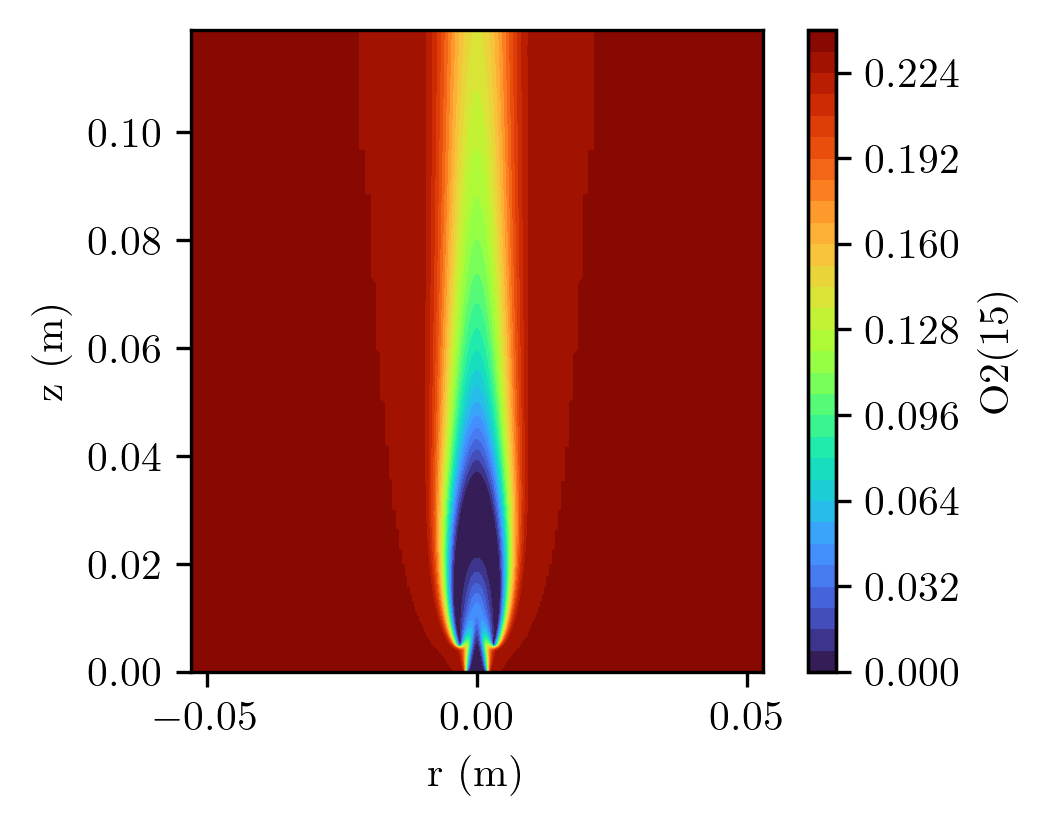

In [14]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.tri as tri
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.rcParams['text.usetex'] = True
from matplotlib import rc
rc('font',**{'family':'sansserif', 'size':10})
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Plotting utilities
def plot_contour_tri(r, z, f, mirror=False, cbar_label='', filename=''):
    '''
    
    Parameters
    ----------
    r : numpy array
        Radial coordinate.
    z : numpy array
        Axial coordinate.
    f : numpy array
        Feature to plot.
    mirror : bool, optional
        If True, it will mirror the solution. The default is False.
    cbar_label : string, optional
        The label of the colorbar. The default is ''.
    filename : string, optional
        Path to save the plot. The default is ''.

    Returns
    -------
    None.

    '''
    
    fig, ax = plt.subplots(figsize=(3.5,3.5))
    levels = 32
    
    triang = tri.Triangulation(r, z)
    cs = ax.tricontourf(triang, f, levels, cmap='turbo')
                 
    if mirror:
        triang_mirror = tri.Triangulation(-r, z)
        cs = ax.tricontourf(triang_mirror, f, levels, cmap='turbo')
                 
    ax.set_aspect('equal')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)
    ax.set_xlabel('r (m)')
    ax.set_ylabel('z (m)')
    ax.set_ylim(bottom=0)
    fig.colorbar(cs, cax=cax, format='%.2e')
    cbar = fig.colorbar(cs, cax=cax)
    cbar.set_label(cbar_label)
    fig.tight_layout()

    if filename != '':
        fig.savefig(filename, transparent=True, dpi=600, bbox_inches='tight')    
    
    plt.show()

# Path to the dataset
path = '/Users/alberto/Documents/Teaching/ERCOFTAC/DMD_Peppe'

# We read the dataset with f=10 Hz at timestep t=0 
df = pd.read_csv(f'{path}/output.0', sep='\s+')

xyz = np.array(df[['x[m](2)', 'y[m](3)', 'z[m](4)']]) # x, y, z coordinates

# We select the features that we want to analyse
features = ['T[k](11)', 'H2(12)', 'H(13)', 'O(14)', 'O2(15)', 'OH(16)', 'H2O(17)', 
            'HO2(18)', 'H2O2(19)', 'CH2(22)', 'CH3(24)', 
            'CH4(25)', 'CO(26)', 'CO2(27)', 'CH2O(29)', 
            'CH3OH(32)', 'C2H(33)', 'C2H2(34)', 'C2H3(35)', 'C2H4(36)', 
            'C2H5(37)', 'C2H6(38)', 'HCCO(39)', 'CH2CO(40)', 'N2(42)', 
            'C3H7(44)', 'C3H8(45)', 'CH2CHO(46)', 'CH3CHO(47)']

feature = 'O2(15)'
f = np.array(df[feature])
plot_contour_tri(xyz[:,0], xyz[:,2], f, mirror=True, cbar_label=feature)


## Performing PCA with OpenMORe

Here we do some PCA analysis

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0.968476804068568

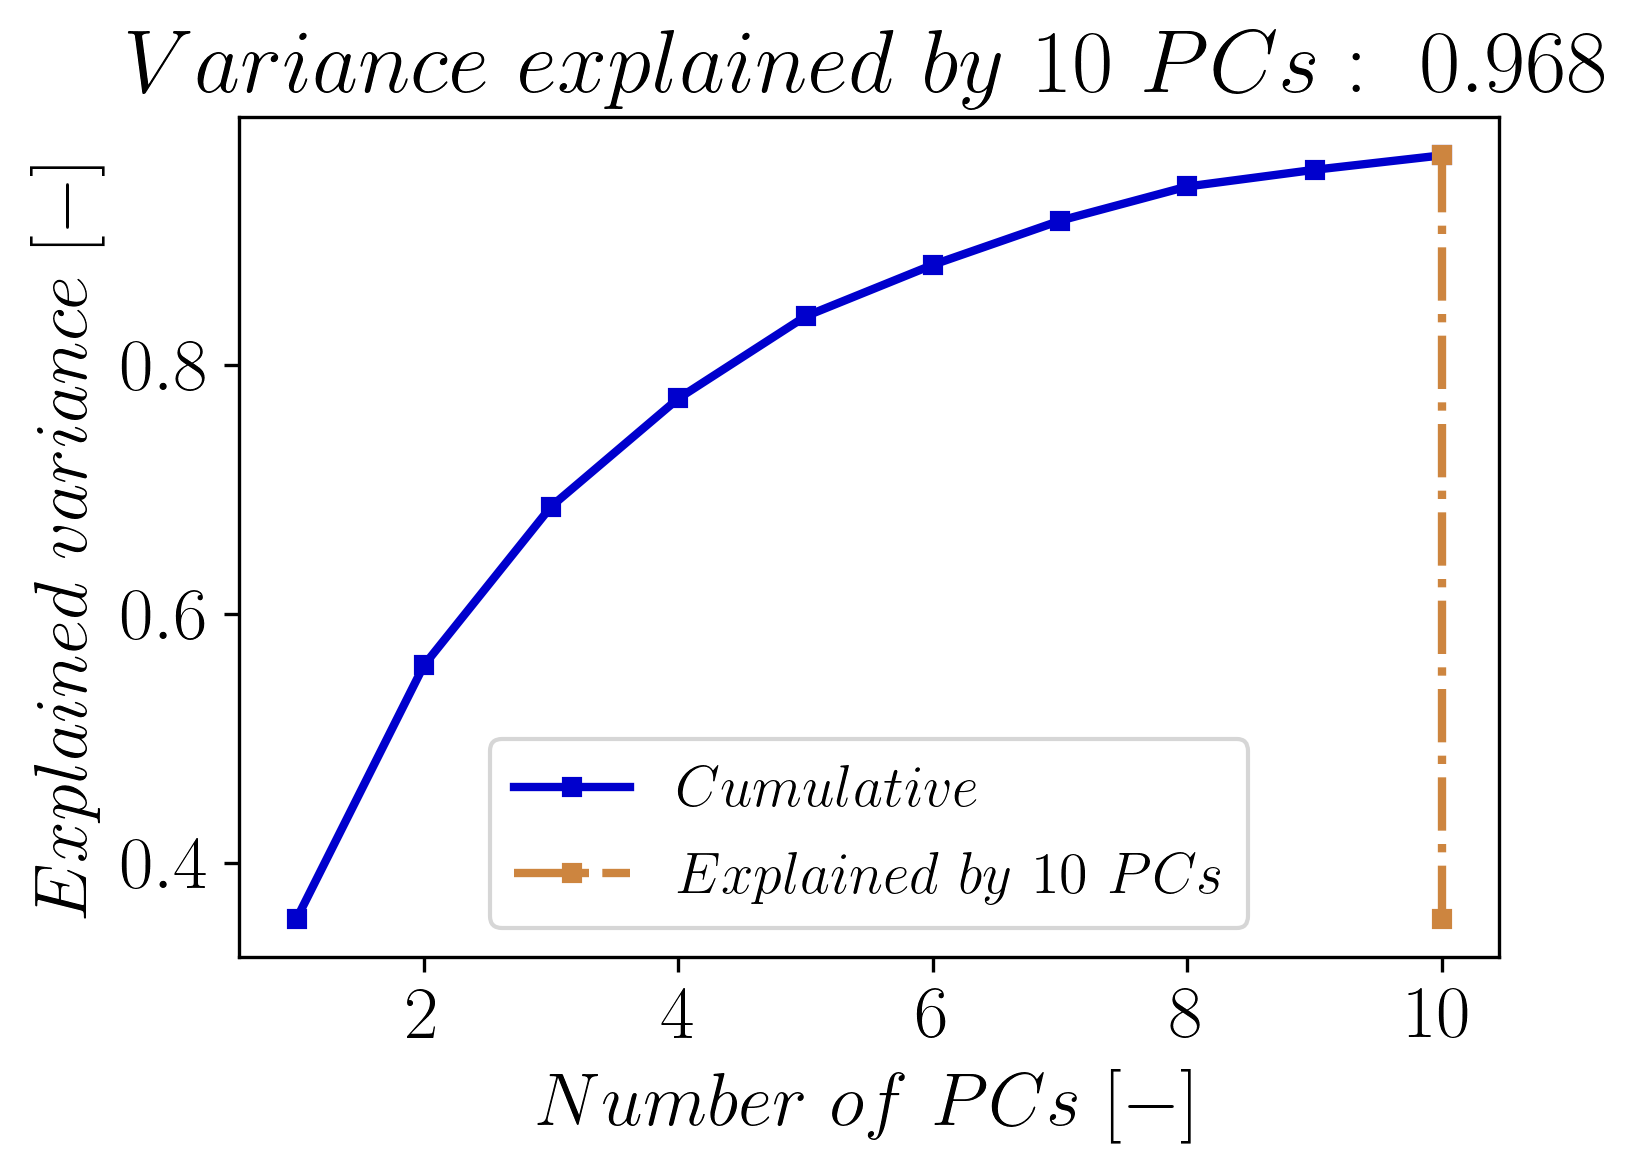

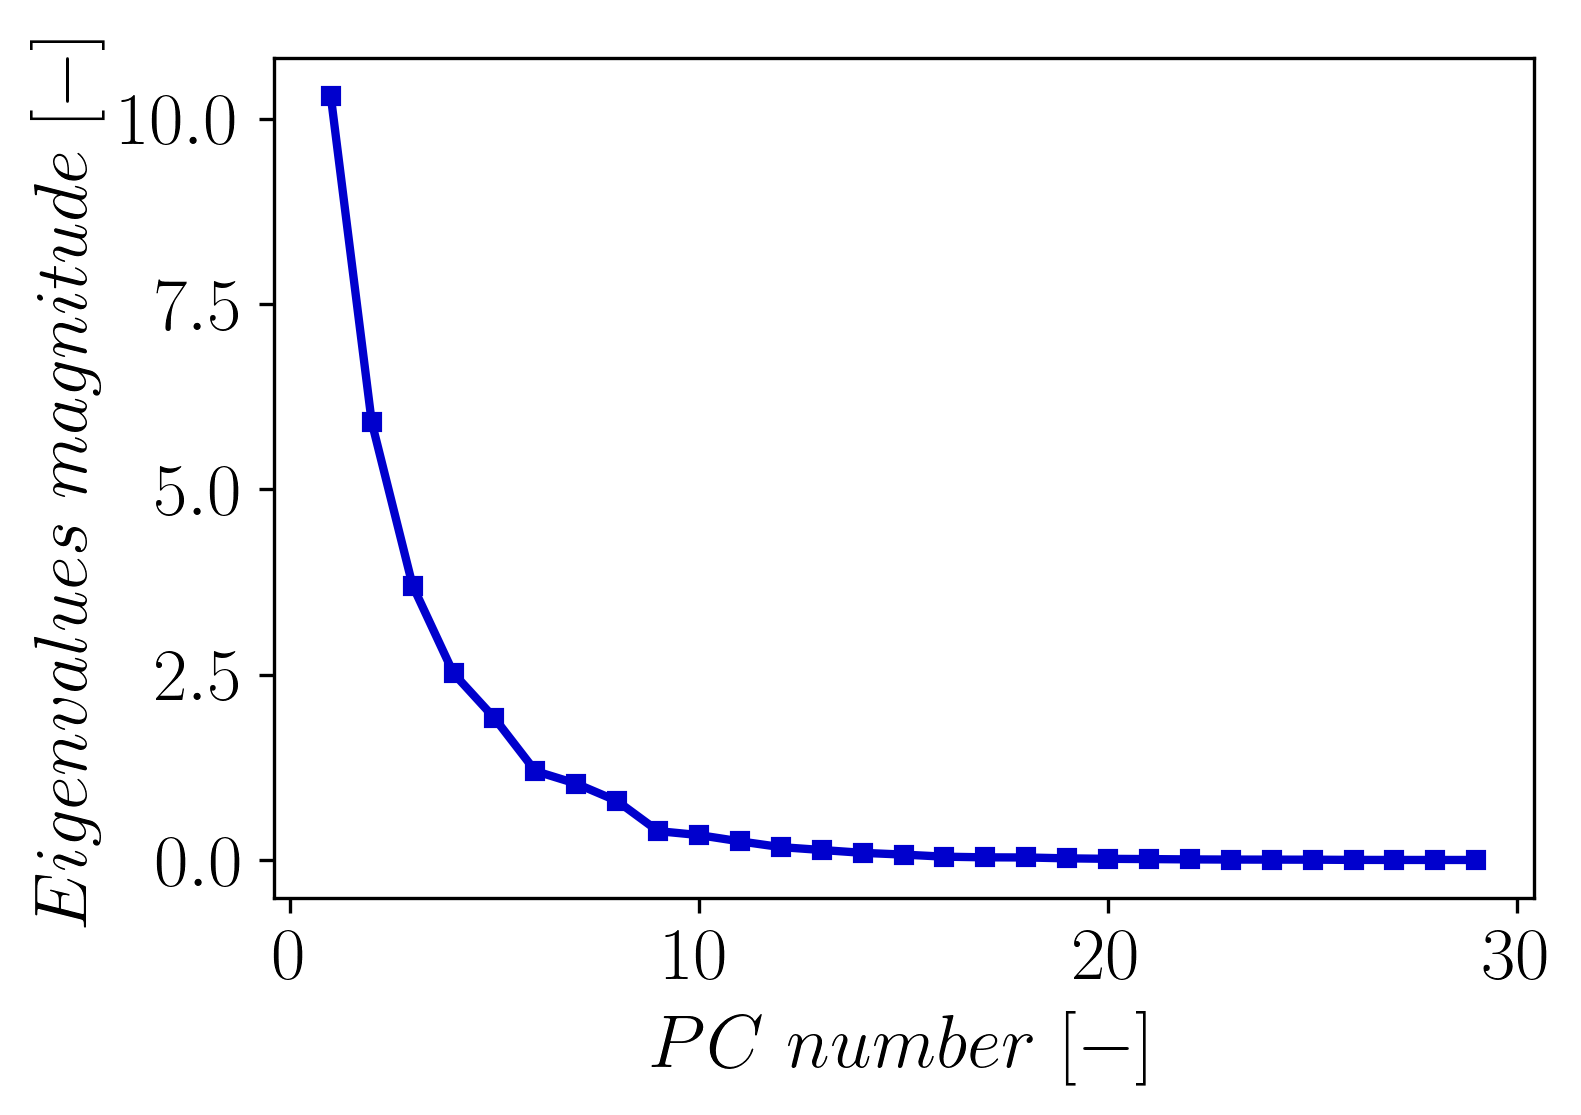

In [15]:
import OpenMORe.model_order_reduction as model_order_reduction
from OpenMORe.utilities import *

# Dictionary with the instruction for the PCA algorithm:
settings ={
    #centering and scaling options
    "center"                    : True,
    "centering_method"          : "mean",
    "scale"                     : True,
    "scaling_method"            : "auto",

    #set the final dimensionality
    "number_of_eigenvectors"    : 10,
    
    #enable to plot the cumulative explained variance
    "enable_plot_variance"      : True,
    
    #set the number of the variable whose reconstruction must be plotted
    "variable_to_plot"          : 0,

}

# We create our data matrix X
X = np.array(df[features])

# Start the dimensionality reduction and the feature extraction step:
# call the PCA class and give in input X and the dictionary with the instructions
model = model_order_reduction.PCA(X, settings)

# Perform the dimensionality reduction via Principal Component Analysis,
# and return the eigenvectors of the reduced manifold ad the PC scores
PCs = model.fit()
Z = model.get_scores()

# Assess the percentage of explained variance if the number of PCs has not
# been set automatically, and plot the result
model.get_explained()

We can check also the quality of the reconstruction using the truncated PCA matrix

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


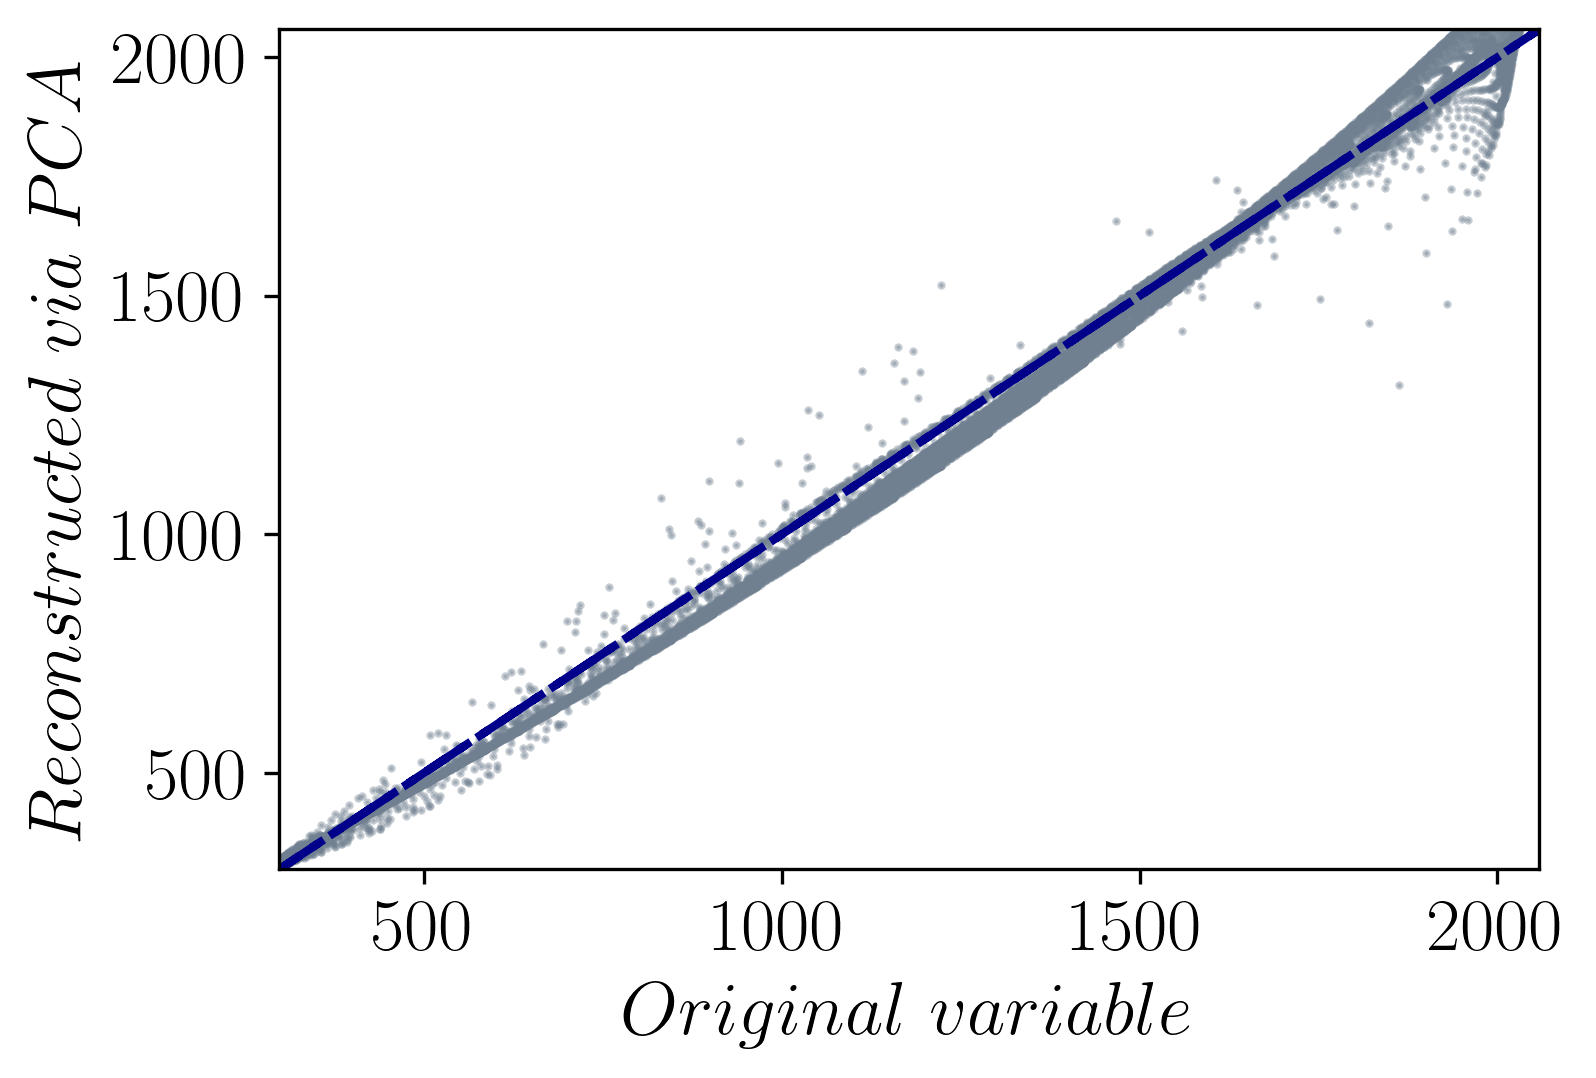

In [16]:
# Reconstruct the matrix from the reduced PCA manifold
X_recovered = model.recover()

# Compare the reconstructed chosen variable "set_num_to_plot" with the
# original one, by means of a parity plot
model.plot_parity()

We can also inspect the PCs to check which are the dominant species.

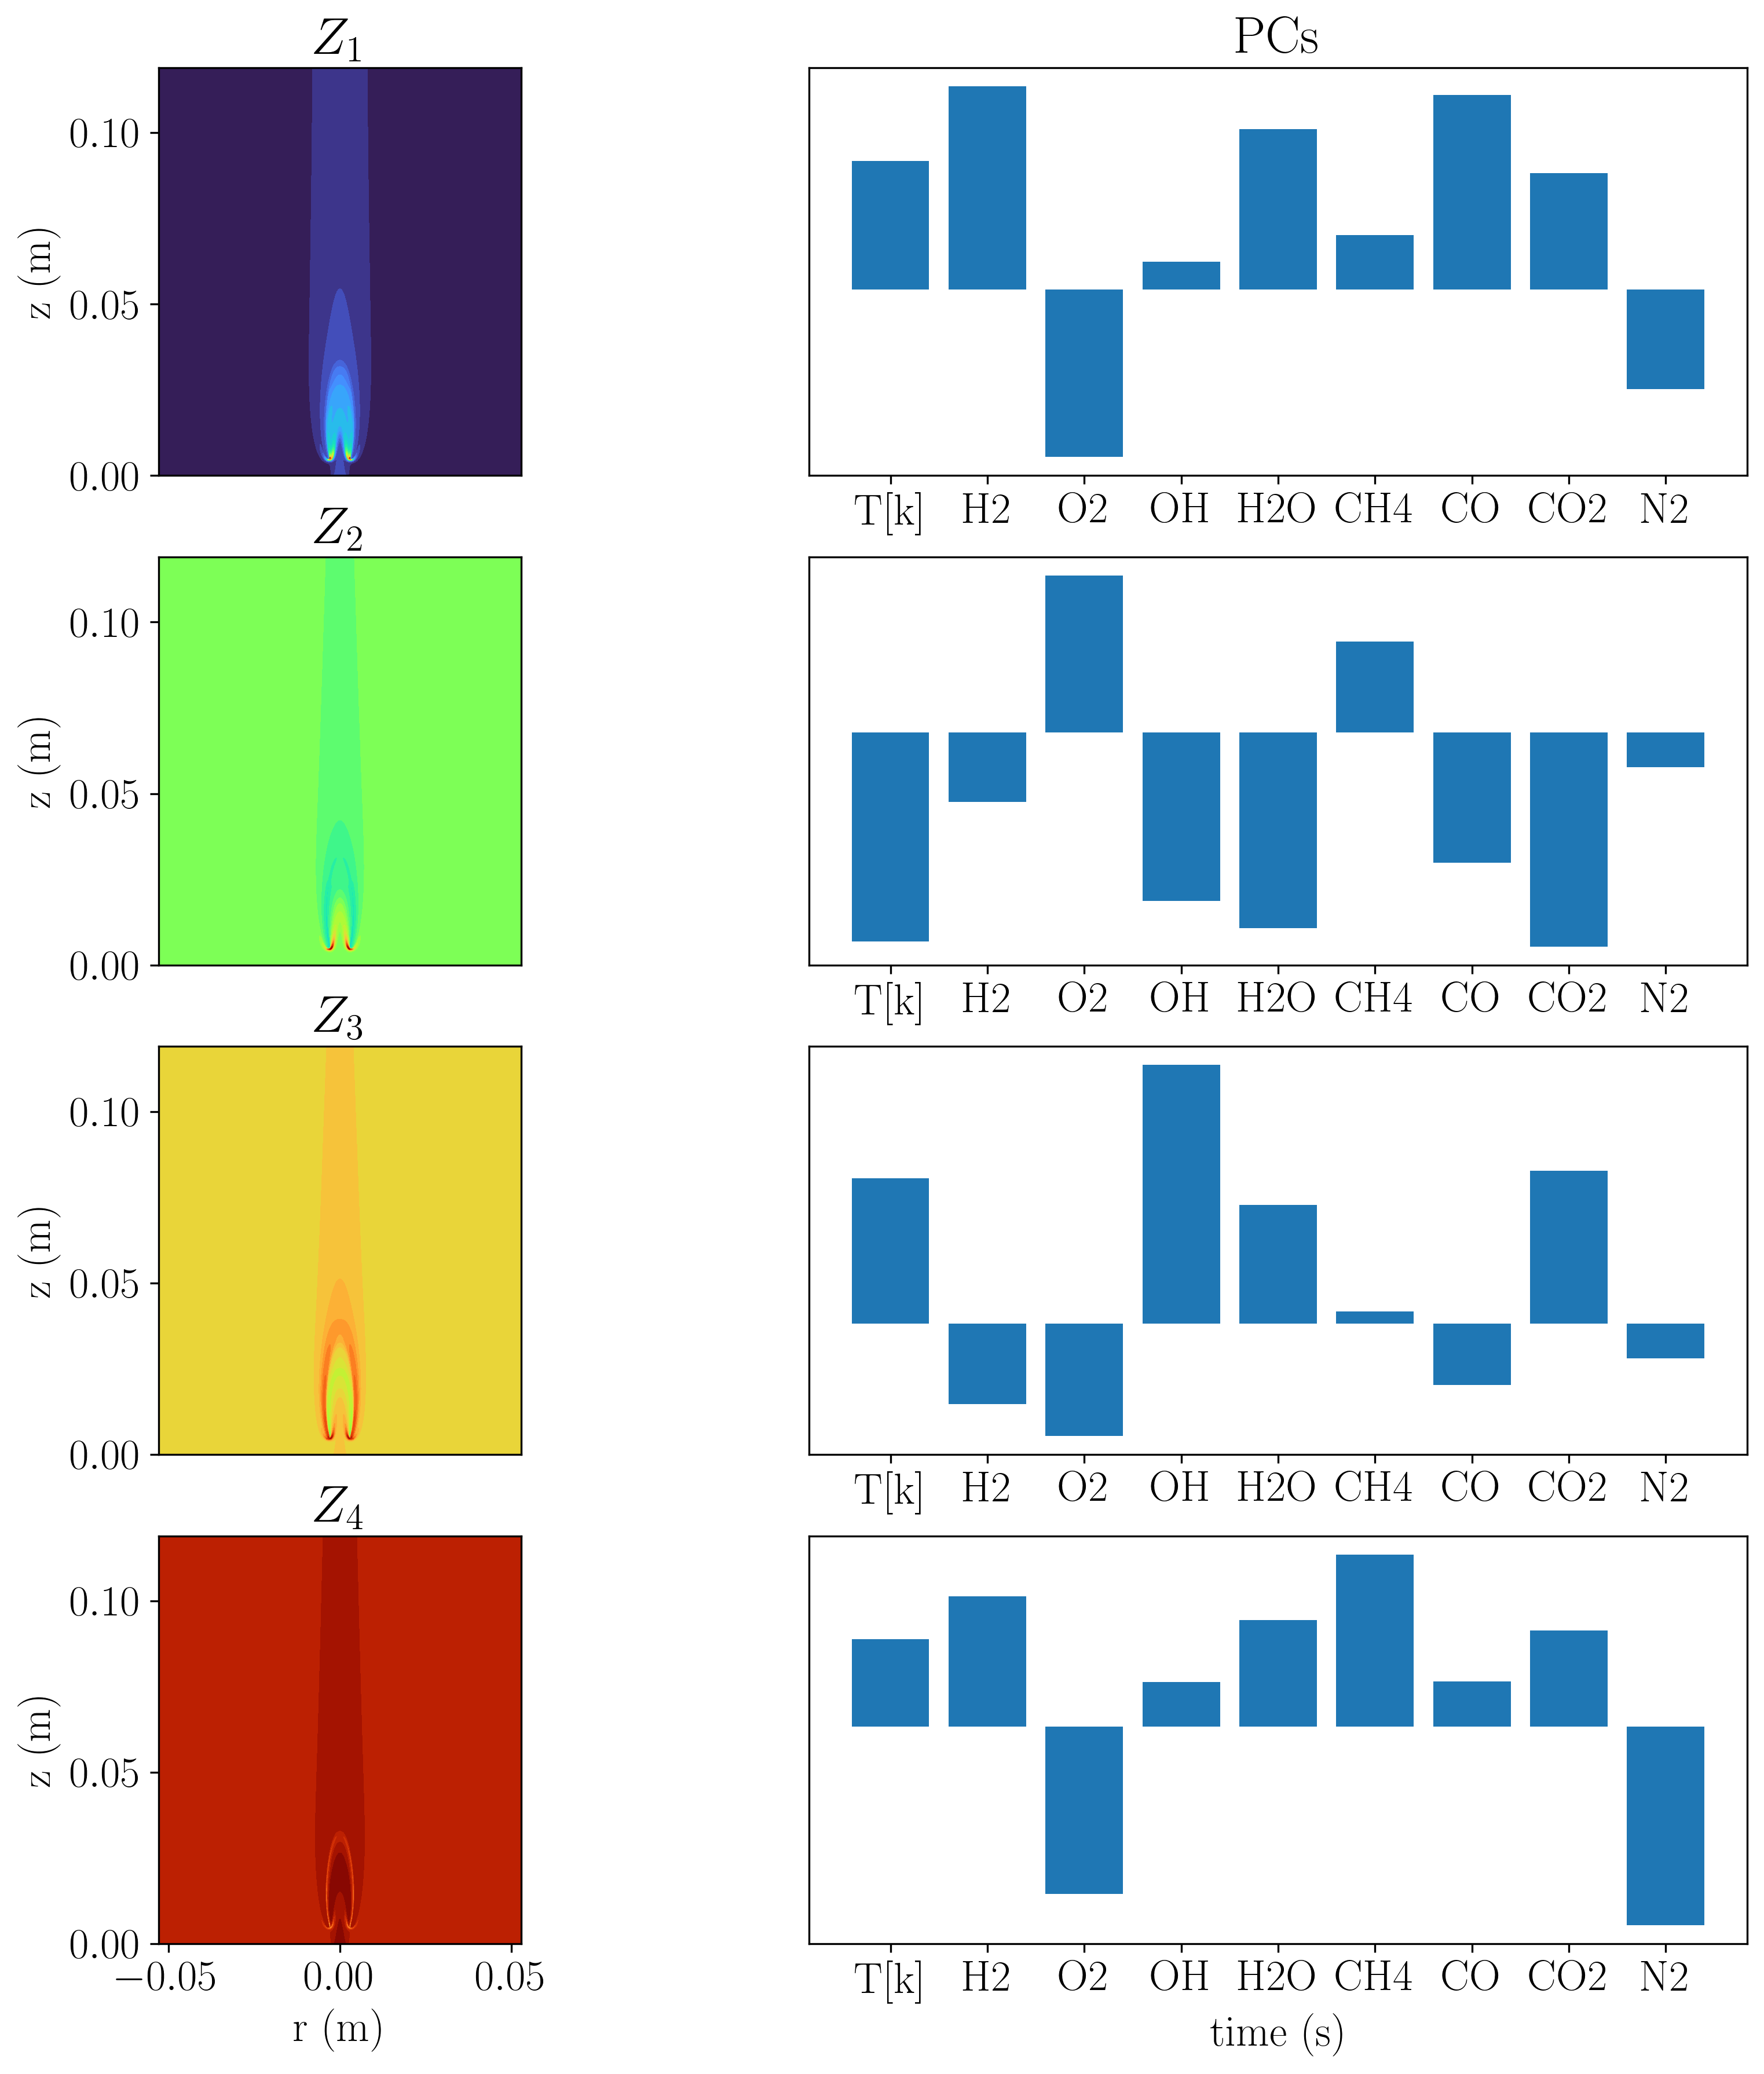

In [17]:
def plot_pcs(r, z, PCs, Z, n_modes, f_r, features, filename=''):
    f_ind = [features.index(f) for f in f_r]
    f_clean = [f[:-4] for f in f_r]
    
    fig, axs = plt.subplots(nrows=n_modes, ncols=2, figsize=(12, n_modes*3))
    levels = 32
    
    r_mirror = np.concatenate((r, -r))
    z_mirror = np.concatenate((z, z))
    
    triang = tri.Triangulation(r_mirror, z_mirror)
    
    for i in range(n_modes):
        mode = np.concatenate((Z[:,i], Z[:,i]))
        axs[i,0].tricontourf(triang, mode, levels, cmap='turbo')
        axs[i,0].set_aspect('equal')
        axs[i,0].set_ylabel('z (m)')
        axs[i,0].set_ylim(bottom=0)
        axs[i,0].set_title(f'$Z_{i+1}$')
        
        if i < n_modes - 1:
            axs[i,0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
            
        else:
            axs[i,0].set_xlabel('r (m)')
            axs[i,1].set_xlabel('time (s)')
        
        axs[i,1].bar(f_clean, PCs[0][f_ind,i])
        axs[i,1].tick_params(axis='y', which='both', left=False, labelleft=False)
        if i == 0:
            axs[i,1].set_title('PCs')
                 
    # fig.tight_layout()
    fig.subplots_adjust(bottom=0.05, top=.95, left=0.05, right=.95, wspace=0.0, hspace=0.2)

    if filename != '':
        fig.savefig(filename, transparent=True, dpi=600, bbox_inches='tight')    
    
    plt.show()


f_r = ['T[k](11)', 'H2(12)', 'O2(15)', 'OH(16)', 'H2O(17)','CH4(25)', 'CO(26)', 
       'CO2(27)', 'N2(42)']

f_ind = [features.index(f) for f in f_r]

n_modes = 4
plot_pcs(xyz[:,0], xyz[:,2], PCs, Z, n_modes, f_r, features)

## LPCA

Here we can do some Local Principal Component Analysis

In [18]:
import OpenMORe.clustering as clustering

# Dictionary with the instruction for the LPCA algorithm:

n_clusters = 7
settings = {
    #centering and scaling options
    "center"                    : True,
    "centering_method"          : "mean",
    "scale"                     : True,
    "scaling_method"            : "auto",

    #set the initialization method (random, observations, kmeans, pkcia, uniform)
    "initialization_method"     : "uniform",

    #set the number of clusters and PCs in each cluster
    "number_of_clusters"        : n_clusters,
    "number_of_eigenvectors"    : 5,

    #enable additional options:
    "correction_factor"         : "off",    # --> enable eventual corrective coefficients for the LPCA algorithm:
                                            #     'off', 'c_range', 'uncorrelation', 'local_variance', 'phc_multi', 'local_skewness' are available

    "classify"                  : False,    # --> call the method to classify a new matrix Y on the basis of the lpca clustering
    "write_on_txt"              : True,     # --> write the idx vector containing the label for each observation
    "evaluate_clustering"       : True,     # --> enable the calculation of indeces to evaluate the goodness of the clustering
    
    #improve the clustering solution via kNN
    "kNN_post"                  : True,     # activate the kNN algorithm once the convergence is achieved
    "neighbors_number"          : 40,       # set the number of neighbors that has to be taken into account
}
    
    
model = clustering.lpca(X, settings)
index = model.fit()

Preprocessing training matrix..
Fitting Local PCA model...
- Iteration number: 1
	Reconstruction error: 1.1200078286257726
	Reconstruction error variance: 0.10714909803176999


/opt/anaconda3/envs/env_ml/lib/python3.7/site-packages/OpenMORe/clustering.py:768: ComplexWarning: Casting complex values to real discards the imaginary part
  sq_rec_err[:,ii] = sq_rec_oss.sum(axis=1)


- Iteration number: 2
	Reconstruction error: 0.2916537596235295
	Reconstruction error variance: 2.840196780152923
- Iteration number: 3
	Reconstruction error: 0.1824607506975494
	Reconstruction error variance: 0.5984465618415689
- Iteration number: 4
	Reconstruction error: 0.15209920608185992
	Reconstruction error variance: 0.19961671988839222
- Iteration number: 5
	Reconstruction error: 0.13509513248682306
	Reconstruction error variance: 0.12586740382149145
- Iteration number: 6
	Reconstruction error: 0.11995562755276697
	Reconstruction error variance: 0.12620920954622494
- Iteration number: 7
	Reconstruction error: 0.09671222025497832
	Reconstruction error variance: 0.24033578421122195
- Iteration number: 8
	Reconstruction error: 0.08826869199304004
	Reconstruction error variance: 0.09565711319936682
- Iteration number: 9
	Reconstruction error: 0.08488852480264539
	Reconstruction error variance: 0.03981889422926222
- Iteration number: 10
	Reconstruction error: 0.08138567191671182
	Re

Observation number: 241
Observation number: 242
Observation number: 243
Observation number: 244
Observation number: 245
Observation number: 246
Observation number: 247
Observation number: 248
Observation number: 249
Observation number: 250
Observation number: 251
Observation number: 252
Observation number: 253
Observation number: 254
Observation number: 255
Observation number: 256
Observation number: 257
Observation number: 258
Observation number: 259
Observation number: 260
Observation number: 261
Observation number: 262
Observation number: 263
Observation number: 264
Observation number: 265
Observation number: 266
Observation number: 267
Observation number: 268
Observation number: 269
Observation number: 270
Observation number: 271
Observation number: 272
Observation number: 273
Observation number: 274
Observation number: 275
Observation number: 276
Observation number: 277
Observation number: 278
Observation number: 279
Observation number: 280
Observation number: 281
Observation numb

Observation number: 628
Observation number: 629
Observation number: 630
Observation number: 631
Observation number: 632
Observation number: 633
Observation number: 634
Observation number: 635
Observation number: 636
Observation number: 637
Observation number: 638
Observation number: 639
Observation number: 640
Observation number: 641
Observation number: 642
Observation number: 643
Observation number: 644
Observation number: 645
Observation number: 646
Observation number: 647
Observation number: 648
Observation number: 649
Observation number: 650
Observation number: 651
Observation number: 652
Observation number: 653
Observation number: 654
Observation number: 655
Observation number: 656
Observation number: 657
Observation number: 658
Observation number: 659
Observation number: 660
Observation number: 661
Observation number: 662
Observation number: 663
Observation number: 664
Observation number: 665
Observation number: 666
Observation number: 667
Observation number: 668
Observation numb

Observation number: 976
Observation number: 977
Observation number: 978
Observation number: 979
Observation number: 980
Observation number: 981
Observation number: 982
Observation number: 983
Observation number: 984
Observation number: 985
Observation number: 986
Observation number: 987
Observation number: 988
Observation number: 989
Observation number: 990
Observation number: 991
Observation number: 992
Observation number: 993
Observation number: 994
Observation number: 995
Observation number: 996
Observation number: 997
Observation number: 998
Observation number: 999
Observation number: 1000
Observation number: 1001
Observation number: 1002
Observation number: 1003
Observation number: 1004
Observation number: 1005
Observation number: 1006
Observation number: 1007
Observation number: 1008
Observation number: 1009
Observation number: 1010
Observation number: 1011
Observation number: 1012
Observation number: 1013
Observation number: 1014
Observation number: 1015
Observation number: 1016

Observation number: 1317
Observation number: 1318
Observation number: 1319
Observation number: 1320
Observation number: 1321
Observation number: 1322
Observation number: 1323
Observation number: 1324
Observation number: 1325
Observation number: 1326
Observation number: 1327
Observation number: 1328
Observation number: 1329
Observation number: 1330
Observation number: 1331
Observation number: 1332
Observation number: 1333
Observation number: 1334
Observation number: 1335
Observation number: 1336
Observation number: 1337
Observation number: 1338
Observation number: 1339
Observation number: 1340
Observation number: 1341
Observation number: 1342
Observation number: 1343
Observation number: 1344
Observation number: 1345
Observation number: 1346
Observation number: 1347
Observation number: 1348
Observation number: 1349
Observation number: 1350
Observation number: 1351
Observation number: 1352
Observation number: 1353
Observation number: 1354
Observation number: 1355
Observation number: 1356


Observation number: 1664
Observation number: 1665
Observation number: 1666
Observation number: 1667
Observation number: 1668
Observation number: 1669
Observation number: 1670
Observation number: 1671
Observation number: 1672
Observation number: 1673
Observation number: 1674
Observation number: 1675
Observation number: 1676
Observation number: 1677
Observation number: 1678
Observation number: 1679
Observation number: 1680
Observation number: 1681
Observation number: 1682
Observation number: 1683
Observation number: 1684
Observation number: 1685
Observation number: 1686
Observation number: 1687
Observation number: 1688
Observation number: 1689
Observation number: 1690
Observation number: 1691
Observation number: 1692
Observation number: 1693
Observation number: 1694
Observation number: 1695
Observation number: 1696
Observation number: 1697
Observation number: 1698
Observation number: 1699
Observation number: 1700
Observation number: 1701
Observation number: 1702
Observation number: 1703


Observation number: 1995
Observation number: 1996
Observation number: 1997
Observation number: 1998
Observation number: 1999
Observation number: 2000
Observation number: 2001
Observation number: 2002
Observation number: 2003
Observation number: 2004
Observation number: 2005
Observation number: 2006
Observation number: 2007
Observation number: 2008
Observation number: 2009
Observation number: 2010
Observation number: 2011
Observation number: 2012
Observation number: 2013
Observation number: 2014
Observation number: 2015
Observation number: 2016
Observation number: 2017
Observation number: 2018
Observation number: 2019
Observation number: 2020
Observation number: 2021
Observation number: 2022
Observation number: 2023
Observation number: 2024
Observation number: 2025
Observation number: 2026
Observation number: 2027
Observation number: 2028
Observation number: 2029
Observation number: 2030
Observation number: 2031
Observation number: 2032
Observation number: 2033
Observation number: 2034


Observation number: 2340
Observation number: 2341
Observation number: 2342
Observation number: 2343
Observation number: 2344
Observation number: 2345
Observation number: 2346
Observation number: 2347
Observation number: 2348
Observation number: 2349
Observation number: 2350
Observation number: 2351
Observation number: 2352
Observation number: 2353
Observation number: 2354
Observation number: 2355
Observation number: 2356
Observation number: 2357
Observation number: 2358
Observation number: 2359
Observation number: 2360
Observation number: 2361
Observation number: 2362
Observation number: 2363
Observation number: 2364
Observation number: 2365
Observation number: 2366
Observation number: 2367
Observation number: 2368
Observation number: 2369
Observation number: 2370
Observation number: 2371
Observation number: 2372
Observation number: 2373
Observation number: 2374
Observation number: 2375
Observation number: 2376
Observation number: 2377
Observation number: 2378
Observation number: 2379


Observation number: 2696
Observation number: 2697
Observation number: 2698
Observation number: 2699
Observation number: 2700
Observation number: 2701
Observation number: 2702
Observation number: 2703
Observation number: 2704
Observation number: 2705
Observation number: 2706
Observation number: 2707
Observation number: 2708
Observation number: 2709
Observation number: 2710
Observation number: 2711
Observation number: 2712
Observation number: 2713
Observation number: 2714
Observation number: 2715
Observation number: 2716
Observation number: 2717
Observation number: 2718
Observation number: 2719
Observation number: 2720
Observation number: 2721
Observation number: 2722
Observation number: 2723
Observation number: 2724
Observation number: 2725
Observation number: 2726
Observation number: 2727
Observation number: 2728
Observation number: 2729
Observation number: 2730
Observation number: 2731
Observation number: 2732
Observation number: 2733
Observation number: 2734
Observation number: 2735


Observation number: 3050
Observation number: 3051
Observation number: 3052
Observation number: 3053
Observation number: 3054
Observation number: 3055
Observation number: 3056
Observation number: 3057
Observation number: 3058
Observation number: 3059
Observation number: 3060
Observation number: 3061
Observation number: 3062
Observation number: 3063
Observation number: 3064
Observation number: 3065
Observation number: 3066
Observation number: 3067
Observation number: 3068
Observation number: 3069
Observation number: 3070
Observation number: 3071
Observation number: 3072
Observation number: 3073
Observation number: 3074
Observation number: 3075
Observation number: 3076
Observation number: 3077
Observation number: 3078
Observation number: 3079
Observation number: 3080
Observation number: 3081
Observation number: 3082
Observation number: 3083
Observation number: 3084
Observation number: 3085
Observation number: 3086
Observation number: 3087
Observation number: 3088
Observation number: 3089


Observation number: 3404
Observation number: 3405
Observation number: 3406
Observation number: 3407
Observation number: 3408
Observation number: 3409
Observation number: 3410
Observation number: 3411
Observation number: 3412
Observation number: 3413
Observation number: 3414
Observation number: 3415
Observation number: 3416
Observation number: 3417
Observation number: 3418
Observation number: 3419
Observation number: 3420
Observation number: 3421
Observation number: 3422
Observation number: 3423
Observation number: 3424
Observation number: 3425
Observation number: 3426
Observation number: 3427
Observation number: 3428
Observation number: 3429
Observation number: 3430
Observation number: 3431
Observation number: 3432
Observation number: 3433
Observation number: 3434
Observation number: 3435
Observation number: 3436
Observation number: 3437
Observation number: 3438
Observation number: 3439
Observation number: 3440
Observation number: 3441
Observation number: 3442
Observation number: 3443


Observation number: 3770
Observation number: 3771
Observation number: 3772
Observation number: 3773
Observation number: 3774
Observation number: 3775
Observation number: 3776
Observation number: 3777
Observation number: 3778
Observation number: 3779
Observation number: 3780
Observation number: 3781
Observation number: 3782
Observation number: 3783
Observation number: 3784
Observation number: 3785
Observation number: 3786
Observation number: 3787
Observation number: 3788
Observation number: 3789
Observation number: 3790
Observation number: 3791
Observation number: 3792
Observation number: 3793
Observation number: 3794
Observation number: 3795
Observation number: 3796
Observation number: 3797
Observation number: 3798
Observation number: 3799
Observation number: 3800
Observation number: 3801
Observation number: 3802
Observation number: 3803
Observation number: 3804
Observation number: 3805
Observation number: 3806
Observation number: 3807
Observation number: 3808
Observation number: 3809


Observation number: 4127
Observation number: 4128
Observation number: 4129
Observation number: 4130
Observation number: 4131
Observation number: 4132
Observation number: 4133
Observation number: 4134
Observation number: 4135
Observation number: 4136
Observation number: 4137
Observation number: 4138
Observation number: 4139
Observation number: 4140
Observation number: 4141
Observation number: 4142
Observation number: 4143
Observation number: 4144
Observation number: 4145
Observation number: 4146
Observation number: 4147
Observation number: 4148
Observation number: 4149
Observation number: 4150
Observation number: 4151
Observation number: 4152
Observation number: 4153
Observation number: 4154
Observation number: 4155
Observation number: 4156
Observation number: 4157
Observation number: 4158
Observation number: 4159
Observation number: 4160
Observation number: 4161
Observation number: 4162
Observation number: 4163
Observation number: 4164
Observation number: 4165
Observation number: 4166


Observation number: 4476
Observation number: 4477
Observation number: 4478
Observation number: 4479
Observation number: 4480
Observation number: 4481
Observation number: 4482
Observation number: 4483
Observation number: 4484
Observation number: 4485
Observation number: 4486
Observation number: 4487
Observation number: 4488
Observation number: 4489
Observation number: 4490
Observation number: 4491
Observation number: 4492
Observation number: 4493
Observation number: 4494
Observation number: 4495
Observation number: 4496
Observation number: 4497
Observation number: 4498
Observation number: 4499
Observation number: 4500
Observation number: 4501
Observation number: 4502
Observation number: 4503
Observation number: 4504
Observation number: 4505
Observation number: 4506
Observation number: 4507
Observation number: 4508
Observation number: 4509
Observation number: 4510
Observation number: 4511
Observation number: 4512
Observation number: 4513
Observation number: 4514
Observation number: 4515


Observation number: 4827
Observation number: 4828
Observation number: 4829
Observation number: 4830
Observation number: 4831
Observation number: 4832
Observation number: 4833
Observation number: 4834
Observation number: 4835
Observation number: 4836
Observation number: 4837
Observation number: 4838
Observation number: 4839
Observation number: 4840
Observation number: 4841
Observation number: 4842
Observation number: 4843
Observation number: 4844
Observation number: 4845
Observation number: 4846
Observation number: 4847
Observation number: 4848
Observation number: 4849
Observation number: 4850
Observation number: 4851
Observation number: 4852
Observation number: 4853
Observation number: 4854
Observation number: 4855
Observation number: 4856
Observation number: 4857
Observation number: 4858
Observation number: 4859
Observation number: 4860
Observation number: 4861
Observation number: 4862
Observation number: 4863
Observation number: 4864
Observation number: 4865
Observation number: 4866


Observation number: 5188
Observation number: 5189
Observation number: 5190
Observation number: 5191
Observation number: 5192
Observation number: 5193
Observation number: 5194
Observation number: 5195
Observation number: 5196
Observation number: 5197
Observation number: 5198
Observation number: 5199
Observation number: 5200
Observation number: 5201
Observation number: 5202
Observation number: 5203
Observation number: 5204
Observation number: 5205
Observation number: 5206
Observation number: 5207
Observation number: 5208
Observation number: 5209
Observation number: 5210
Observation number: 5211
Observation number: 5212
Observation number: 5213
Observation number: 5214
Observation number: 5215
Observation number: 5216
Observation number: 5217
Observation number: 5218
Observation number: 5219
Observation number: 5220
Observation number: 5221
Observation number: 5222
Observation number: 5223
Observation number: 5224
Observation number: 5225
Observation number: 5226
Observation number: 5227


Observation number: 5550
Observation number: 5551
Observation number: 5552
Observation number: 5553
Observation number: 5554
Observation number: 5555
Observation number: 5556
Observation number: 5557
Observation number: 5558
Observation number: 5559
Observation number: 5560
Observation number: 5561
Observation number: 5562
Observation number: 5563
Observation number: 5564
Observation number: 5565
Observation number: 5566
Observation number: 5567
Observation number: 5568
Observation number: 5569
Observation number: 5570
Observation number: 5571
Observation number: 5572
Observation number: 5573
Observation number: 5574
Observation number: 5575
Observation number: 5576
Observation number: 5577
Observation number: 5578
Observation number: 5579
Observation number: 5580
Observation number: 5581
Observation number: 5582
Observation number: 5583
Observation number: 5584
Observation number: 5585
Observation number: 5586
Observation number: 5587
Observation number: 5588
Observation number: 5589


Observation number: 5878
Observation number: 5879
Observation number: 5880
Observation number: 5881
Observation number: 5882
Observation number: 5883
Observation number: 5884
Observation number: 5885
Observation number: 5886
Observation number: 5887
Observation number: 5888
Observation number: 5889
Observation number: 5890
Observation number: 5891
Observation number: 5892
Observation number: 5893
Observation number: 5894
Observation number: 5895
Observation number: 5896
Observation number: 5897
Observation number: 5898
Observation number: 5899
Observation number: 5900
Observation number: 5901
Observation number: 5902
Observation number: 5903
Observation number: 5904
Observation number: 5905
Observation number: 5906
Observation number: 5907
Observation number: 5908
Observation number: 5909
Observation number: 5910
Observation number: 5911
Observation number: 5912
Observation number: 5913
Observation number: 5914
Observation number: 5915
Observation number: 5916
Observation number: 5917


Observation number: 6238
Observation number: 6239
Observation number: 6240
Observation number: 6241
Observation number: 6242
Observation number: 6243
Observation number: 6244
Observation number: 6245
Observation number: 6246
Observation number: 6247
Observation number: 6248
Observation number: 6249
Observation number: 6250
Observation number: 6251
Observation number: 6252
Observation number: 6253
Observation number: 6254
Observation number: 6255
Observation number: 6256
Observation number: 6257
Observation number: 6258
Observation number: 6259
Observation number: 6260
Observation number: 6261
Observation number: 6262
Observation number: 6263
Observation number: 6264
Observation number: 6265
Observation number: 6266
Observation number: 6267
Observation number: 6268
Observation number: 6269
Observation number: 6270
Observation number: 6271
Observation number: 6272
Observation number: 6273
Observation number: 6274
Observation number: 6275
Observation number: 6276
Observation number: 6277


Observation number: 6598
Observation number: 6599
Observation number: 6600
Observation number: 6601
Observation number: 6602
Observation number: 6603
Observation number: 6604
Observation number: 6605
Observation number: 6606
Observation number: 6607
Observation number: 6608
Observation number: 6609
Observation number: 6610
Observation number: 6611
Observation number: 6612
Observation number: 6613
Observation number: 6614
Observation number: 6615
Observation number: 6616
Observation number: 6617
Observation number: 6618
Observation number: 6619
Observation number: 6620
Observation number: 6621
Observation number: 6622
Observation number: 6623
Observation number: 6624
Observation number: 6625
Observation number: 6626
Observation number: 6627
Observation number: 6628
Observation number: 6629
Observation number: 6630
Observation number: 6631
Observation number: 6632
Observation number: 6633
Observation number: 6634
Observation number: 6635
Observation number: 6636
Observation number: 6637


Observation number: 6933
Observation number: 6934
Observation number: 6935
Observation number: 6936
Observation number: 6937
Observation number: 6938
Observation number: 6939
Observation number: 6940
Observation number: 6941
Observation number: 6942
Observation number: 6943
Observation number: 6944
Observation number: 6945
Observation number: 6946
Observation number: 6947
Observation number: 6948
Observation number: 6949
Observation number: 6950
Observation number: 6951
Observation number: 6952
Observation number: 6953
Observation number: 6954
Observation number: 6955
Observation number: 6956
Observation number: 6957
Observation number: 6958
Observation number: 6959
Observation number: 6960
Observation number: 6961
Observation number: 6962
Observation number: 6963
Observation number: 6964
Observation number: 6965
Observation number: 6966
Observation number: 6967
Observation number: 6968
Observation number: 6969
Observation number: 6970
Observation number: 6971
Observation number: 6972


Observation number: 7293
Observation number: 7294
Observation number: 7295
Observation number: 7296
Observation number: 7297
Observation number: 7298
Observation number: 7299
Observation number: 7300
Observation number: 7301
Observation number: 7302
Observation number: 7303
Observation number: 7304
Observation number: 7305
Observation number: 7306
Observation number: 7307
Observation number: 7308
Observation number: 7309
Observation number: 7310
Observation number: 7311
Observation number: 7312
Observation number: 7313
Observation number: 7314
Observation number: 7315
Observation number: 7316
Observation number: 7317
Observation number: 7318
Observation number: 7319
Observation number: 7320
Observation number: 7321
Observation number: 7322
Observation number: 7323
Observation number: 7324
Observation number: 7325
Observation number: 7326
Observation number: 7327
Observation number: 7328
Observation number: 7329
Observation number: 7330
Observation number: 7331
Observation number: 7332


Observation number: 7641
Observation number: 7642
Observation number: 7643
Observation number: 7644
Observation number: 7645
Observation number: 7646
Observation number: 7647
Observation number: 7648
Observation number: 7649
Observation number: 7650
Observation number: 7651
Observation number: 7652
Observation number: 7653
Observation number: 7654
Observation number: 7655
Observation number: 7656
Observation number: 7657
Observation number: 7658
Observation number: 7659
Observation number: 7660
Observation number: 7661
Observation number: 7662
Observation number: 7663
Observation number: 7664
Observation number: 7665
Observation number: 7666
Observation number: 7667
Observation number: 7668
Observation number: 7669
Observation number: 7670
Observation number: 7671
Observation number: 7672
Observation number: 7673
Observation number: 7674
Observation number: 7675
Observation number: 7676
Observation number: 7677
Observation number: 7678
Observation number: 7679
Observation number: 7680


Observation number: 8003
Observation number: 8004
Observation number: 8005
Observation number: 8006
Observation number: 8007
Observation number: 8008
Observation number: 8009
Observation number: 8010
Observation number: 8011
Observation number: 8012
Observation number: 8013
Observation number: 8014
Observation number: 8015
Observation number: 8016
Observation number: 8017
Observation number: 8018
Observation number: 8019
Observation number: 8020
Observation number: 8021
Observation number: 8022
Observation number: 8023
Observation number: 8024
Observation number: 8025
Observation number: 8026
Observation number: 8027
Observation number: 8028
Observation number: 8029
Observation number: 8030
Observation number: 8031
Observation number: 8032
Observation number: 8033
Observation number: 8034
Observation number: 8035
Observation number: 8036
Observation number: 8037
Observation number: 8038
Observation number: 8039
Observation number: 8040
Observation number: 8041
Observation number: 8042


Observation number: 8365
Observation number: 8366
Observation number: 8367
Observation number: 8368
Observation number: 8369
Observation number: 8370
Observation number: 8371
Observation number: 8372
Observation number: 8373
Observation number: 8374
Observation number: 8375
Observation number: 8376
Observation number: 8377
Observation number: 8378
Observation number: 8379
Observation number: 8380
Observation number: 8381
Observation number: 8382
Observation number: 8383
Observation number: 8384
Observation number: 8385
Observation number: 8386
Observation number: 8387
Observation number: 8388
Observation number: 8389
Observation number: 8390
Observation number: 8391
Observation number: 8392
Observation number: 8393
Observation number: 8394
Observation number: 8395
Observation number: 8396
Observation number: 8397
Observation number: 8398
Observation number: 8399
Observation number: 8400
Observation number: 8401
Observation number: 8402
Observation number: 8403
Observation number: 8404


Observation number: 8717
Observation number: 8718
Observation number: 8719
Observation number: 8720
Observation number: 8721
Observation number: 8722
Observation number: 8723
Observation number: 8724
Observation number: 8725
Observation number: 8726
Observation number: 8727
Observation number: 8728
Observation number: 8729
Observation number: 8730
Observation number: 8731
Observation number: 8732
Observation number: 8733
Observation number: 8734
Observation number: 8735
Observation number: 8736
Observation number: 8737
Observation number: 8738
Observation number: 8739
Observation number: 8740
Observation number: 8741
Observation number: 8742
Observation number: 8743
Observation number: 8744
Observation number: 8745
Observation number: 8746
Observation number: 8747
Observation number: 8748
Observation number: 8749
Observation number: 8750
Observation number: 8751
Observation number: 8752
Observation number: 8753
Observation number: 8754
Observation number: 8755
Observation number: 8756


Observation number: 9082
Observation number: 9083
Observation number: 9084
Observation number: 9085
Observation number: 9086
Observation number: 9087
Observation number: 9088
Observation number: 9089
Observation number: 9090
Observation number: 9091
Observation number: 9092
Observation number: 9093
Observation number: 9094
Observation number: 9095
Observation number: 9096
Observation number: 9097
Observation number: 9098
Observation number: 9099
Observation number: 9100
Observation number: 9101
Observation number: 9102
Observation number: 9103
Observation number: 9104
Observation number: 9105
Observation number: 9106
Observation number: 9107
Observation number: 9108
Observation number: 9109
Observation number: 9110
Observation number: 9111
Observation number: 9112
Observation number: 9113
Observation number: 9114
Observation number: 9115
Observation number: 9116
Observation number: 9117
Observation number: 9118
Observation number: 9119
Observation number: 9120
Observation number: 9121


Observation number: 9423
Observation number: 9424
Observation number: 9425
Observation number: 9426
Observation number: 9427
Observation number: 9428
Observation number: 9429
Observation number: 9430
Observation number: 9431
Observation number: 9432
Observation number: 9433
Observation number: 9434
Observation number: 9435
Observation number: 9436
Observation number: 9437
Observation number: 9438
Observation number: 9439
Observation number: 9440
Observation number: 9441
Observation number: 9442
Observation number: 9443
Observation number: 9444
Observation number: 9445
Observation number: 9446
Observation number: 9447
Observation number: 9448
Observation number: 9449
Observation number: 9450
Observation number: 9451
Observation number: 9452
Observation number: 9453
Observation number: 9454
Observation number: 9455
Observation number: 9456
Observation number: 9457
Observation number: 9458
Observation number: 9459
Observation number: 9460
Observation number: 9461
Observation number: 9462


Observation number: 9781
Observation number: 9782
Observation number: 9783
Observation number: 9784
Observation number: 9785
Observation number: 9786
Observation number: 9787
Observation number: 9788
Observation number: 9789
Observation number: 9790
Observation number: 9791
Observation number: 9792
Observation number: 9793
Observation number: 9794
Observation number: 9795
Observation number: 9796
Observation number: 9797
Observation number: 9798
Observation number: 9799
Observation number: 9800
Observation number: 9801
Observation number: 9802
Observation number: 9803
Observation number: 9804
Observation number: 9805
Observation number: 9806
Observation number: 9807
Observation number: 9808
Observation number: 9809
Observation number: 9810
Observation number: 9811
Observation number: 9812
Observation number: 9813
Observation number: 9814
Observation number: 9815
Observation number: 9816
Observation number: 9817
Observation number: 9818
Observation number: 9819
Observation number: 9820


Observation number: 10131
Observation number: 10132
Observation number: 10133
Observation number: 10134
Observation number: 10135
Observation number: 10136
Observation number: 10137
Observation number: 10138
Observation number: 10139
Observation number: 10140
Observation number: 10141
Observation number: 10142
Observation number: 10143
Observation number: 10144
Observation number: 10145
Observation number: 10146
Observation number: 10147
Observation number: 10148
Observation number: 10149
Observation number: 10150
Observation number: 10151
Observation number: 10152
Observation number: 10153
Observation number: 10154
Observation number: 10155
Observation number: 10156
Observation number: 10157
Observation number: 10158
Observation number: 10159
Observation number: 10160
Observation number: 10161
Observation number: 10162
Observation number: 10163
Observation number: 10164
Observation number: 10165
Observation number: 10166
Observation number: 10167
Observation number: 10168
Observation 

Observation number: 10484
Observation number: 10485
Observation number: 10486
Observation number: 10487
Observation number: 10488
Observation number: 10489
Observation number: 10490
Observation number: 10491
Observation number: 10492
Observation number: 10493
Observation number: 10494
Observation number: 10495
Observation number: 10496
Observation number: 10497
Observation number: 10498
Observation number: 10499
Observation number: 10500
Observation number: 10501
Observation number: 10502
Observation number: 10503
Observation number: 10504
Observation number: 10505
Observation number: 10506
Observation number: 10507
Observation number: 10508
Observation number: 10509
Observation number: 10510
Observation number: 10511
Observation number: 10512
Observation number: 10513
Observation number: 10514
Observation number: 10515
Observation number: 10516
Observation number: 10517
Observation number: 10518
Observation number: 10519
Observation number: 10520
Observation number: 10521
Observation 

Observation number: 10847
Observation number: 10848
Observation number: 10849
Observation number: 10850
Observation number: 10851
Observation number: 10852
Observation number: 10853
Observation number: 10854
Observation number: 10855
Observation number: 10856
Observation number: 10857
Observation number: 10858
Observation number: 10859
Observation number: 10860
Observation number: 10861
Observation number: 10862
Observation number: 10863
Observation number: 10864
Observation number: 10865
Observation number: 10866
Observation number: 10867
Observation number: 10868
Observation number: 10869
Observation number: 10870
Observation number: 10871
Observation number: 10872
Observation number: 10873
Observation number: 10874
Observation number: 10875
Observation number: 10876
Observation number: 10877
Observation number: 10878
Observation number: 10879
Observation number: 10880
Observation number: 10881
Observation number: 10882
Observation number: 10883
Observation number: 10884
Observation 

Observation number: 11202
Observation number: 11203
Observation number: 11204
Observation number: 11205
Observation number: 11206
Observation number: 11207
Observation number: 11208
Observation number: 11209
Observation number: 11210
Observation number: 11211
Observation number: 11212
Observation number: 11213
Observation number: 11214
Observation number: 11215
Observation number: 11216
Observation number: 11217
Observation number: 11218
Observation number: 11219
Observation number: 11220
Observation number: 11221
Observation number: 11222
Observation number: 11223
Observation number: 11224
Observation number: 11225
Observation number: 11226
Observation number: 11227
Observation number: 11228
Observation number: 11229
Observation number: 11230
Observation number: 11231
Observation number: 11232
Observation number: 11233
Observation number: 11234
Observation number: 11235
Observation number: 11236
Observation number: 11237
Observation number: 11238
Observation number: 11239
Observation 

Observation number: 11556
Observation number: 11557
Observation number: 11558
Observation number: 11559
Observation number: 11560
Observation number: 11561
Observation number: 11562
Observation number: 11563
Observation number: 11564
Observation number: 11565
Observation number: 11566
Observation number: 11567
Observation number: 11568
Observation number: 11569
Observation number: 11570
Observation number: 11571
Observation number: 11572
Observation number: 11573
Observation number: 11574
Observation number: 11575
Observation number: 11576
Observation number: 11577
Observation number: 11578
Observation number: 11579
Observation number: 11580
Observation number: 11581
Observation number: 11582
Observation number: 11583
Observation number: 11584
Observation number: 11585
Observation number: 11586
Observation number: 11587
Observation number: 11588
Observation number: 11589
Observation number: 11590
Observation number: 11591
Observation number: 11592
Observation number: 11593
Observation 

Observation number: 11914
Observation number: 11915
Observation number: 11916
Observation number: 11917
Observation number: 11918
Observation number: 11919
Observation number: 11920
Observation number: 11921
Observation number: 11922
Observation number: 11923
Observation number: 11924
Observation number: 11925
Observation number: 11926
Observation number: 11927
Observation number: 11928
Observation number: 11929
Observation number: 11930
Observation number: 11931
Observation number: 11932
Observation number: 11933
Observation number: 11934
Observation number: 11935
Observation number: 11936
Observation number: 11937
Observation number: 11938
Observation number: 11939
Observation number: 11940
Observation number: 11941
Observation number: 11942
Observation number: 11943
Observation number: 11944
Observation number: 11945
Observation number: 11946
Observation number: 11947
Observation number: 11948
Observation number: 11949
Observation number: 11950
Observation number: 11951
Observation 

Observation number: 12262
Observation number: 12263
Observation number: 12264
Observation number: 12265
Observation number: 12266
Observation number: 12267
Observation number: 12268
Observation number: 12269
Observation number: 12270
Observation number: 12271
Observation number: 12272
Observation number: 12273
Observation number: 12274
Observation number: 12275
Observation number: 12276
Observation number: 12277
Observation number: 12278
Observation number: 12279
Observation number: 12280
Observation number: 12281
Observation number: 12282
Observation number: 12283
Observation number: 12284
Observation number: 12285
Observation number: 12286
Observation number: 12287
Observation number: 12288
Observation number: 12289
Observation number: 12290
Observation number: 12291
Observation number: 12292
Observation number: 12293
Observation number: 12294
Observation number: 12295
Observation number: 12296
Observation number: 12297
Observation number: 12298
Observation number: 12299
Observation 

Observation number: 12614
Observation number: 12615
Observation number: 12616
Observation number: 12617
Observation number: 12618
Observation number: 12619
Observation number: 12620
Observation number: 12621
Observation number: 12622
Observation number: 12623
Observation number: 12624
Observation number: 12625
Observation number: 12626
Observation number: 12627
Observation number: 12628
Observation number: 12629
Observation number: 12630
Observation number: 12631
Observation number: 12632
Observation number: 12633
Observation number: 12634
Observation number: 12635
Observation number: 12636
Observation number: 12637
Observation number: 12638
Observation number: 12639
Observation number: 12640
Observation number: 12641
Observation number: 12642
Observation number: 12643
Observation number: 12644
Observation number: 12645
Observation number: 12646
Observation number: 12647
Observation number: 12648
Observation number: 12649
Observation number: 12650
Observation number: 12651
Observation 

Observation number: 12953
Observation number: 12954
Observation number: 12955
Observation number: 12956
Observation number: 12957
Observation number: 12958
Observation number: 12959
Observation number: 12960
Observation number: 12961
Observation number: 12962
Observation number: 12963
Observation number: 12964
Observation number: 12965
Observation number: 12966
Observation number: 12967
Observation number: 12968
Observation number: 12969
Observation number: 12970
Observation number: 12971
Observation number: 12972
Observation number: 12973
Observation number: 12974
Observation number: 12975
Observation number: 12976
Observation number: 12977
Observation number: 12978
Observation number: 12979
Observation number: 12980
Observation number: 12981
Observation number: 12982
Observation number: 12983
Observation number: 12984
Observation number: 12985
Observation number: 12986
Observation number: 12987
Observation number: 12988
Observation number: 12989
Observation number: 12990
Observation 

Observation number: 13312
Observation number: 13313
Observation number: 13314
Observation number: 13315
Observation number: 13316
Observation number: 13317
Observation number: 13318
Observation number: 13319
Observation number: 13320
Observation number: 13321
Observation number: 13322
Observation number: 13323
Observation number: 13324
Observation number: 13325
Observation number: 13326
Observation number: 13327
Observation number: 13328
Observation number: 13329
Observation number: 13330
Observation number: 13331
Observation number: 13332
Observation number: 13333
Observation number: 13334
Observation number: 13335
Observation number: 13336
Observation number: 13337
Observation number: 13338
Observation number: 13339
Observation number: 13340
Observation number: 13341
Observation number: 13342
Observation number: 13343
Observation number: 13344
Observation number: 13345
Observation number: 13346
Observation number: 13347
Observation number: 13348
Observation number: 13349
Observation 

Observation number: 13668
Observation number: 13669
Observation number: 13670
Observation number: 13671
Observation number: 13672
Observation number: 13673
Observation number: 13674
Observation number: 13675
Observation number: 13676
Observation number: 13677
Observation number: 13678
Observation number: 13679
Observation number: 13680
Observation number: 13681
Observation number: 13682
Observation number: 13683
Observation number: 13684
Observation number: 13685
Observation number: 13686
Observation number: 13687
Observation number: 13688
Observation number: 13689
Observation number: 13690
Observation number: 13691
Observation number: 13692
Observation number: 13693
Observation number: 13694
Observation number: 13695
Observation number: 13696
Observation number: 13697
Observation number: 13698
Observation number: 13699
Observation number: 13700
Observation number: 13701
Observation number: 13702
Observation number: 13703
Observation number: 13704
Observation number: 13705
Observation 

Observation number: 14014
Observation number: 14015
Observation number: 14016
Observation number: 14017
Observation number: 14018
Observation number: 14019
Observation number: 14020
Observation number: 14021
Observation number: 14022
Observation number: 14023
Observation number: 14024
Observation number: 14025
Observation number: 14026
Observation number: 14027
Observation number: 14028
Observation number: 14029
Observation number: 14030
Observation number: 14031
Observation number: 14032
Observation number: 14033
Observation number: 14034
Observation number: 14035
Observation number: 14036
Observation number: 14037
Observation number: 14038
Observation number: 14039
Observation number: 14040
Observation number: 14041
Observation number: 14042
Observation number: 14043
Observation number: 14044
Observation number: 14045
Observation number: 14046
Observation number: 14047
Observation number: 14048
Observation number: 14049
Observation number: 14050
Observation number: 14051
Observation 

Observation number: 14363
Observation number: 14364
Observation number: 14365
Observation number: 14366
Observation number: 14367
Observation number: 14368
Observation number: 14369
Observation number: 14370
Observation number: 14371
Observation number: 14372
Observation number: 14373
Observation number: 14374
Observation number: 14375
Observation number: 14376
Observation number: 14377
Observation number: 14378
Observation number: 14379
Observation number: 14380
Observation number: 14381
Observation number: 14382
Observation number: 14383
Observation number: 14384
Observation number: 14385
Observation number: 14386
Observation number: 14387
Observation number: 14388
Observation number: 14389
Observation number: 14390
Observation number: 14391
Observation number: 14392
Observation number: 14393
Observation number: 14394
Observation number: 14395
Observation number: 14396
Observation number: 14397
Observation number: 14398
Observation number: 14399
Observation number: 14400
Observation 

Observation number: 14680
Observation number: 14681
Observation number: 14682
Observation number: 14683
Observation number: 14684
Observation number: 14685
Observation number: 14686
Observation number: 14687
Observation number: 14688
Observation number: 14689
Observation number: 14690
Observation number: 14691
Observation number: 14692
Observation number: 14693
Observation number: 14694
Observation number: 14695
Observation number: 14696
Observation number: 14697
Observation number: 14698
Observation number: 14699
Observation number: 14700
Observation number: 14701
Observation number: 14702
Observation number: 14703
Observation number: 14704
Observation number: 14705
Observation number: 14706
Observation number: 14707
Observation number: 14708
Observation number: 14709
Observation number: 14710
Observation number: 14711
Observation number: 14712
Observation number: 14713
Observation number: 14714
Observation number: 14715
Observation number: 14716
Observation number: 14717
Observation 

Observation number: 15016
Observation number: 15017
Observation number: 15018
Observation number: 15019
Observation number: 15020
Observation number: 15021
Observation number: 15022
Observation number: 15023
Observation number: 15024
Observation number: 15025
Observation number: 15026
Observation number: 15027
Observation number: 15028
Observation number: 15029
Observation number: 15030
Observation number: 15031
Observation number: 15032
Observation number: 15033
Observation number: 15034
Observation number: 15035
Observation number: 15036
Observation number: 15037
Observation number: 15038
Observation number: 15039
Observation number: 15040
Observation number: 15041
Observation number: 15042
Observation number: 15043
Observation number: 15044
Observation number: 15045
Observation number: 15046
Observation number: 15047
Observation number: 15048
Observation number: 15049
Observation number: 15050
Observation number: 15051
Observation number: 15052
Observation number: 15053
Observation 

Observation number: 15335
Observation number: 15336
Observation number: 15337
Observation number: 15338
Observation number: 15339
Observation number: 15340
Observation number: 15341
Observation number: 15342
Observation number: 15343
Observation number: 15344
Observation number: 15345
Observation number: 15346
Observation number: 15347
Observation number: 15348
Observation number: 15349
Observation number: 15350
Observation number: 15351
Observation number: 15352
Observation number: 15353
Observation number: 15354
Observation number: 15355
Observation number: 15356
Observation number: 15357
Observation number: 15358
Observation number: 15359
Observation number: 15360
Observation number: 15361
Observation number: 15362
Observation number: 15363
Observation number: 15364
Observation number: 15365
Observation number: 15366
Observation number: 15367
Observation number: 15368
Observation number: 15369
Observation number: 15370
Observation number: 15371
Observation number: 15372
Observation 

Observation number: 15689
Observation number: 15690
Observation number: 15691
Observation number: 15692
Observation number: 15693
Observation number: 15694
Observation number: 15695
Observation number: 15696
Observation number: 15697
Observation number: 15698
Observation number: 15699
Observation number: 15700
Observation number: 15701
Observation number: 15702
Observation number: 15703
Observation number: 15704
Observation number: 15705
Observation number: 15706
Observation number: 15707
Observation number: 15708
Observation number: 15709
Observation number: 15710
Observation number: 15711
Observation number: 15712
Observation number: 15713
Observation number: 15714
Observation number: 15715
Observation number: 15716
Observation number: 15717
Observation number: 15718
Observation number: 15719
Observation number: 15720
Observation number: 15721
Observation number: 15722
Observation number: 15723
Observation number: 15724
Observation number: 15725
Observation number: 15726
Observation 

Observation number: 16052
Observation number: 16053
Observation number: 16054
Observation number: 16055
Observation number: 16056
Observation number: 16057
Observation number: 16058
Observation number: 16059
Observation number: 16060
Observation number: 16061
Observation number: 16062
Observation number: 16063
Observation number: 16064
Observation number: 16065
Observation number: 16066
Observation number: 16067
Observation number: 16068
Observation number: 16069
Observation number: 16070
Observation number: 16071
Observation number: 16072
Observation number: 16073
Observation number: 16074
Observation number: 16075
Observation number: 16076
Observation number: 16077
Observation number: 16078
Observation number: 16079
Observation number: 16080
Observation number: 16081
Observation number: 16082
Observation number: 16083
Observation number: 16084
Observation number: 16085
Observation number: 16086
Observation number: 16087
Observation number: 16088
Observation number: 16089
Observation 

Observation number: 16401
Observation number: 16402
Observation number: 16403
Observation number: 16404
Observation number: 16405
Observation number: 16406
Observation number: 16407
Observation number: 16408
Observation number: 16409
Observation number: 16410
Observation number: 16411
Observation number: 16412
Observation number: 16413
Observation number: 16414
Observation number: 16415
Observation number: 16416
Observation number: 16417
Observation number: 16418
Observation number: 16419
Observation number: 16420
Observation number: 16421
Observation number: 16422
Observation number: 16423
Observation number: 16424
Observation number: 16425
Observation number: 16426
Observation number: 16427
Observation number: 16428
Observation number: 16429
Observation number: 16430
Observation number: 16431
Observation number: 16432
Observation number: 16433
Observation number: 16434
Observation number: 16435
Observation number: 16436
Observation number: 16437
Observation number: 16438
Observation 

Observation number: 16759
Observation number: 16760
Observation number: 16761
Observation number: 16762
Observation number: 16763
Observation number: 16764
Observation number: 16765
Observation number: 16766
Observation number: 16767
Observation number: 16768
Observation number: 16769
Observation number: 16770
Observation number: 16771
Observation number: 16772
Observation number: 16773
Observation number: 16774
Observation number: 16775
Observation number: 16776
Observation number: 16777
Observation number: 16778
Observation number: 16779
Observation number: 16780
Observation number: 16781
Observation number: 16782
Observation number: 16783
Observation number: 16784
Observation number: 16785
Observation number: 16786
Observation number: 16787
Observation number: 16788
Observation number: 16789
Observation number: 16790
Observation number: 16791
Observation number: 16792
Observation number: 16793
Observation number: 16794
Observation number: 16795
Observation number: 16796
Observation 

Observation number: 17121
Observation number: 17122
Observation number: 17123
Observation number: 17124
Observation number: 17125
Observation number: 17126
Observation number: 17127
Observation number: 17128
Observation number: 17129
Observation number: 17130
Observation number: 17131
Observation number: 17132
Observation number: 17133
Observation number: 17134
Observation number: 17135
Observation number: 17136
Observation number: 17137
Observation number: 17138
Observation number: 17139
Observation number: 17140
Observation number: 17141
Observation number: 17142
Observation number: 17143
Observation number: 17144
Observation number: 17145
Observation number: 17146
Observation number: 17147
Observation number: 17148
Observation number: 17149
Observation number: 17150
Observation number: 17151
Observation number: 17152
Observation number: 17153
Observation number: 17154
Observation number: 17155
Observation number: 17156
Observation number: 17157
Observation number: 17158
Observation 

Observation number: 17467
Observation number: 17468
Observation number: 17469
Observation number: 17470
Observation number: 17471
Observation number: 17472
Observation number: 17473
Observation number: 17474
Observation number: 17475
Observation number: 17476
Observation number: 17477
Observation number: 17478
Observation number: 17479
Observation number: 17480
Observation number: 17481
Observation number: 17482
Observation number: 17483
Observation number: 17484
Observation number: 17485
Observation number: 17486
Observation number: 17487
Observation number: 17488
Observation number: 17489
Observation number: 17490
Observation number: 17491
Observation number: 17492
Observation number: 17493
Observation number: 17494
Observation number: 17495
Observation number: 17496
Observation number: 17497
Observation number: 17498
Observation number: 17499
Observation number: 17500
Observation number: 17501
Observation number: 17502
Observation number: 17503
Observation number: 17504
Observation 

Observation number: 17829
Observation number: 17830
Observation number: 17831
Observation number: 17832
Observation number: 17833
Observation number: 17834
Observation number: 17835
Observation number: 17836
Observation number: 17837
Observation number: 17838
Observation number: 17839
Observation number: 17840
Observation number: 17841
Observation number: 17842
Observation number: 17843
Observation number: 17844
Observation number: 17845
Observation number: 17846
Observation number: 17847
Observation number: 17848
Observation number: 17849
Observation number: 17850
Observation number: 17851
Observation number: 17852
Observation number: 17853
Observation number: 17854
Observation number: 17855
Observation number: 17856
Observation number: 17857
Observation number: 17858
Observation number: 17859
Observation number: 17860
Observation number: 17861
Observation number: 17862
Observation number: 17863
Observation number: 17864
Observation number: 17865
Observation number: 17866
Observation 

Observation number: 18190
Observation number: 18191
Observation number: 18192
Observation number: 18193
Observation number: 18194
Observation number: 18195
Observation number: 18196
Observation number: 18197
Observation number: 18198
Observation number: 18199
Observation number: 18200
Observation number: 18201
Observation number: 18202
Observation number: 18203
Observation number: 18204
Observation number: 18205
Observation number: 18206
Observation number: 18207
Observation number: 18208
Observation number: 18209
Observation number: 18210
Observation number: 18211
Observation number: 18212
Observation number: 18213
Observation number: 18214
Observation number: 18215
Observation number: 18216
Observation number: 18217
Observation number: 18218
Observation number: 18219
Observation number: 18220
Observation number: 18221
Observation number: 18222
Observation number: 18223
Observation number: 18224
Observation number: 18225
Observation number: 18226
Observation number: 18227
Observation 

Observation number: 18541
Observation number: 18542
Observation number: 18543
Observation number: 18544
Observation number: 18545
Observation number: 18546
Observation number: 18547
Observation number: 18548
Observation number: 18549
Observation number: 18550
Observation number: 18551
Observation number: 18552
Observation number: 18553
Observation number: 18554
Observation number: 18555
Observation number: 18556
Observation number: 18557
Observation number: 18558
Observation number: 18559
Observation number: 18560
Observation number: 18561
Observation number: 18562
Observation number: 18563
Observation number: 18564
Observation number: 18565
Observation number: 18566
Observation number: 18567
Observation number: 18568
Observation number: 18569
Observation number: 18570
Observation number: 18571
Observation number: 18572
Observation number: 18573
Observation number: 18574
Observation number: 18575
Observation number: 18576
Observation number: 18577
Observation number: 18578
Observation 

Observation number: 18897
Observation number: 18898
Observation number: 18899
Observation number: 18900
Observation number: 18901
Observation number: 18902
Observation number: 18903
Observation number: 18904
Observation number: 18905
Observation number: 18906
Observation number: 18907
Observation number: 18908
Observation number: 18909
Observation number: 18910
Observation number: 18911
Observation number: 18912
Observation number: 18913
Observation number: 18914
Observation number: 18915
Observation number: 18916
Observation number: 18917
Observation number: 18918
Observation number: 18919
Observation number: 18920
Observation number: 18921
Observation number: 18922
Observation number: 18923
Observation number: 18924
Observation number: 18925
Observation number: 18926
Observation number: 18927
Observation number: 18928
Observation number: 18929
Observation number: 18930
Observation number: 18931
Observation number: 18932
Observation number: 18933
Observation number: 18934
Observation 

Observation number: 19249
Observation number: 19250
Observation number: 19251
Observation number: 19252
Observation number: 19253
Observation number: 19254
Observation number: 19255
Observation number: 19256
Observation number: 19257
Observation number: 19258
Observation number: 19259
Observation number: 19260
Observation number: 19261
Observation number: 19262
Observation number: 19263
Observation number: 19264
Observation number: 19265
Observation number: 19266
Observation number: 19267
Observation number: 19268
Observation number: 19269
Observation number: 19270
Observation number: 19271
Observation number: 19272
Observation number: 19273
Observation number: 19274
Observation number: 19275
Observation number: 19276
Observation number: 19277
Observation number: 19278
Observation number: 19279
Observation number: 19280
Observation number: 19281
Observation number: 19282
Observation number: 19283
Observation number: 19284
Observation number: 19285
Observation number: 19286
Observation 

Observation number: 19613
Observation number: 19614
Observation number: 19615
Observation number: 19616
Observation number: 19617
Observation number: 19618
Observation number: 19619
Observation number: 19620
Observation number: 19621
Observation number: 19622
Observation number: 19623
Observation number: 19624
Observation number: 19625
Observation number: 19626
Observation number: 19627
Observation number: 19628
Observation number: 19629
Observation number: 19630
Observation number: 19631
Observation number: 19632
Observation number: 19633
Observation number: 19634
Observation number: 19635
Observation number: 19636
Observation number: 19637
Observation number: 19638
Observation number: 19639
Observation number: 19640
Observation number: 19641
Observation number: 19642
Observation number: 19643
Observation number: 19644
Observation number: 19645
Observation number: 19646
Observation number: 19647
Observation number: 19648
Observation number: 19649
Observation number: 19650
Observation 

Observation number: 19974
Observation number: 19975
Observation number: 19976
Observation number: 19977
Observation number: 19978
Observation number: 19979
Observation number: 19980
Observation number: 19981
Observation number: 19982
Observation number: 19983
Observation number: 19984
Observation number: 19985
Observation number: 19986
Observation number: 19987
Observation number: 19988
Observation number: 19989
Observation number: 19990
Observation number: 19991
Observation number: 19992
Observation number: 19993
Observation number: 19994
Observation number: 19995
Observation number: 19996
Observation number: 19997
Observation number: 19998
Observation number: 19999
Observation number: 20000
Observation number: 20001
Observation number: 20002
Observation number: 20003
Observation number: 20004
Observation number: 20005
Observation number: 20006
Observation number: 20007
Observation number: 20008
Observation number: 20009
Observation number: 20010
Observation number: 20011
Observation 

Observation number: 20341
Observation number: 20342
Observation number: 20343
Observation number: 20344
Observation number: 20345
Observation number: 20346
Observation number: 20347
Observation number: 20348
Observation number: 20349
Observation number: 20350
Observation number: 20351
Observation number: 20352
Observation number: 20353
Observation number: 20354
Observation number: 20355
Observation number: 20356
Observation number: 20357
Observation number: 20358
Observation number: 20359
Observation number: 20360
Observation number: 20361
Observation number: 20362
Observation number: 20363
Observation number: 20364
Observation number: 20365
Observation number: 20366
Observation number: 20367
Observation number: 20368
Observation number: 20369
Observation number: 20370
Observation number: 20371
Observation number: 20372
Observation number: 20373
Observation number: 20374
Observation number: 20375
Observation number: 20376
Observation number: 20377
Observation number: 20378
Observation 

Observation number: 20699
Observation number: 20700
Observation number: 20701
Observation number: 20702
Observation number: 20703
Observation number: 20704
Observation number: 20705
Observation number: 20706
Observation number: 20707
Observation number: 20708
Observation number: 20709
Observation number: 20710
Observation number: 20711
Observation number: 20712
Observation number: 20713
Observation number: 20714
Observation number: 20715
Observation number: 20716
Observation number: 20717
Observation number: 20718
Observation number: 20719
Observation number: 20720
Observation number: 20721
Observation number: 20722
Observation number: 20723
Observation number: 20724
Observation number: 20725
Observation number: 20726
Observation number: 20727
Observation number: 20728
Observation number: 20729
Observation number: 20730
Observation number: 20731
Observation number: 20732
Observation number: 20733
Observation number: 20734
Observation number: 20735
Observation number: 20736
Observation 

Observation number: 21058
Observation number: 21059
Observation number: 21060
Observation number: 21061
Observation number: 21062
Observation number: 21063
Observation number: 21064
Observation number: 21065
Observation number: 21066
Observation number: 21067
Observation number: 21068
Observation number: 21069
Observation number: 21070
Observation number: 21071
Observation number: 21072
Observation number: 21073
Observation number: 21074
Observation number: 21075
Observation number: 21076
Observation number: 21077
Observation number: 21078
Observation number: 21079
Observation number: 21080
Observation number: 21081
Observation number: 21082
Observation number: 21083
Observation number: 21084
Observation number: 21085
Observation number: 21086
Observation number: 21087
Observation number: 21088
Observation number: 21089
Observation number: 21090
Observation number: 21091
Observation number: 21092
Observation number: 21093
Observation number: 21094
Observation number: 21095
Observation 

In [19]:
#evaluate the clustering solution
PHC_coeff, PHC_deviations = evaluate_clustering_PHC(X, index)

#evaluate the clustering solution by means of the Davies-Bouldin index. 
#the input matrix must be preprocessed first
X_tilde = center_scale(X, center(X, method=settings["centering_method"]), scale(X, method=settings["scaling_method"]))
DB = evaluate_clustering_DB(X_tilde, index)

print(f'DB index equal to: {DB}')
print(f'Average PHC is: {np.mean(PHC_coeff)}')

DB index equal to: 1.2647887850529762
Average PHC is: 323.9477713854539


The number of points in cluster 1 = 698
The number of points in cluster 2 = 151
The number of points in cluster 3 = 1214
The number of points in cluster 4 = 1084
The number of points in cluster 5 = 5518
The number of points in cluster 6 = 79
The number of points in cluster 7 = 12590


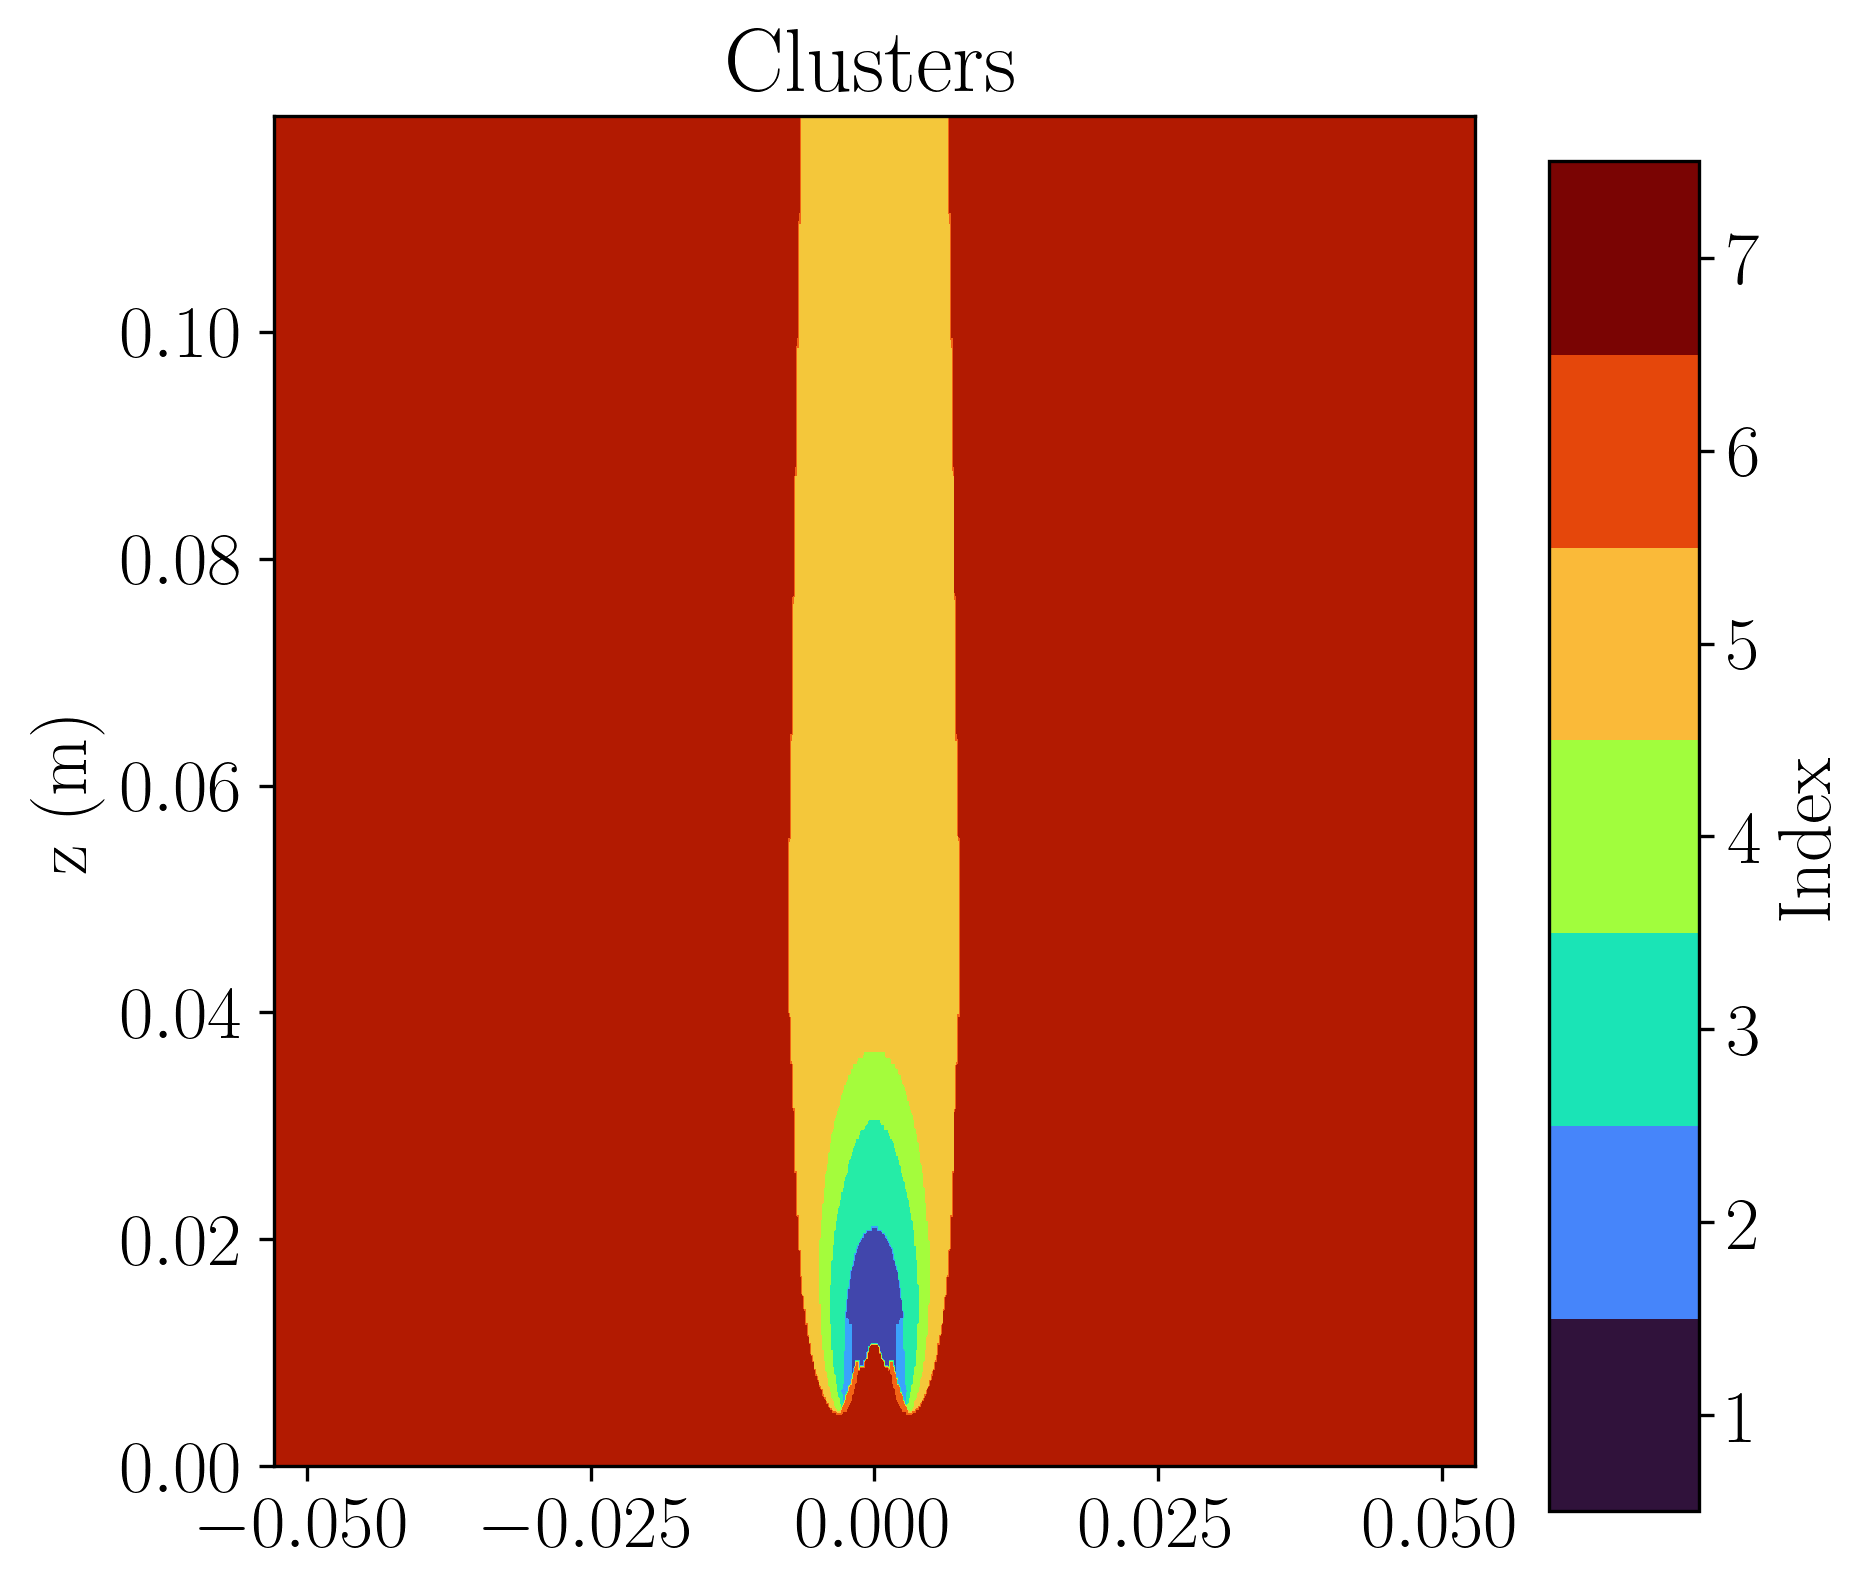

In [20]:
def plot_clustering(r, z, index, n_clusters, filename=''):
    fig, ax = plt.subplots(figsize=(5, 5))
    # levels = n_clusters
    levels = np.linspace(0.5, n_clusters+0.5, n_clusters+1)
    cbticks = np.linspace(1, n_clusters, n_clusters)
    cmap = mpl.cm.turbo
    
    r_mirror = np.concatenate((r, -r))
    z_mirror = np.concatenate((z, z))
    
    triang = tri.Triangulation(r_mirror, z_mirror)
    index = index + 1
    index_mirror = np.concatenate((index, index))
    ax.tricontourf(triang, index_mirror, levels, cmap=cmap )
    ax.set_aspect('equal')
    ax.set_ylabel('z (m)')
    ax.set_ylim(bottom=0)
    ax.set_title('Clusters')
    
    cb_ax = fig.add_axes([0.95, 0.02, 0.1, 0.9])
    
    # bounds = np.linspace(0.5, 8.5, levels+1)
    # # norm = mpl.colors.Normalize(vmin=index.min()+0.5, vmax=index.max()+1.5, levels=n_clusters)
    norm = mpl.colors.BoundaryNorm(levels, cmap.N)

    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cb_ax, 
                  orientation='vertical', label='Index', ticks=cbticks)
    
    # fig.colorbar(trcf)
                     
    # fig.tight_layout()
    fig.subplots_adjust(bottom=0.05, top=.95, left=0.05, right=.95, wspace=0.0, hspace=0.2)

    if filename != '':
        fig.savefig(filename, transparent=True, dpi=600, bbox_inches='tight')    
    
    plt.show()

for i in range(n_clusters):
    mask = index == i
    nb_points = np.sum(mask)
    print(f'The number of points in cluster {i+1} = {nb_points}')
    
plot_clustering(xyz[:,0], xyz[:,2], index, n_clusters)